In [21]:
import numpy as np
import matplotlib.pyplot as plt
import sionna
import scipy
from mpl_toolkits.mplot3d import Axes3D
import drjit as dr
import mitsuba as mi
from matplotlib import colormaps
import pandas as pd

In [2]:
FC = 8e9
BW = 20e6
D_BY_LAMBDA = 0.5
N_TX = 50
N_RX = 10
N_ROWS = 10
N_COLS = 5
N_ROWS_RX = 1
N_COLS_RX = 1
PI = np.pi
# TX_LOC = [41,4,19]
TX_LOC = [41,8,49]
UE_Z = 1.83
# TX_LOC = [180,200,75]
RX0_LOC = [-291,60, UE_Z]
RX1_LOC = [50,56, UE_Z]
RX2_LOC = [-25,56, UE_Z]
RX3_LOC = [-200,0, UE_Z]
RX4_LOC = [-245,-52, UE_Z]
RX5_LOC = [62,-52, UE_Z]
RX6_LOC = [0,-10, UE_Z]
RX7_LOC = [-134,97, UE_Z]
RX8_LOC = [183,-131, UE_Z]
RX9_LOC = [-1, 123, UE_Z]

rx_pos = [RX0_LOC, RX1_LOC, RX2_LOC, RX3_LOC, RX4_LOC, \
          RX5_LOC, RX6_LOC, RX7_LOC, RX8_LOC, RX9_LOC]
# rx_pos = [[np.random.randint(-150, 150), np.random.randint(-150, 150), 1.83] for _ in range(10)]

def create_e(n, delta, omega):
    e = np.empty((n,), dtype = np.complex64)
    for i in range(n):
        e[i] = np.exp(-1j*2*PI*delta*omega*i)
    return e * 1 / np.sqrt(n)

def create_U_P2P(n, delta):
    U = []
    for i in range(n):
        U.append(create_e(n, delta, i / (n * delta)))
    return np.array(U)

scene = sionna.rt.load_scene(sionna.rt.scene.etoile)
scene.frequency = FC
print(rx_pos)

[[-291, 60, 1.83], [50, 56, 1.83], [-25, 56, 1.83], [-200, 0, 1.83], [-245, -52, 1.83], [62, -52, 1.83], [0, -10, 1.83], [-134, 97, 1.83], [183, -131, 1.83], [-1, 123, 1.83]]


In [3]:
power_watts = 10
power_dbm = 10 * np.log10(power_watts / 10**-3)
print("Power in watts: ", power_watts)
print("Power in dBm: ", power_dbm)
scene.tx_array = sionna.rt.PlanarArray(num_rows=N_ROWS,
                             num_cols=N_COLS,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="dipole",
                             polarization="V")
#tr38901

scene.rx_array = sionna.rt.PlanarArray(num_rows=N_ROWS_RX,
                             num_cols=N_COLS_RX,
                             vertical_spacing=D_BY_LAMBDA,
                             horizontal_spacing=D_BY_LAMBDA,
                             pattern="dipole",
                             polarization="V")

tx = sionna.rt.Transmitter(name="tx",
                 position=TX_LOC,
                 display_radius=6,
                 power_dbm = power_dbm)

scene.add(tx)

for i in range(N_RX):
    scene.remove(f"rx-{i}")
    rx = sionna.rt.Receiver(name = f"rx-{i}",
                            position = rx_pos[i],
                            # position = rx_pos[i],
                            display_radius =6)
    scene.add(rx)

# rx = sionna.rt.Receiver(name="rx",
#               position=RX7_LOC,
#               display_radius=2)

# scene.add(rx)

# tx.look_at(rx)

Power in watts:  10
Power in dBm:  40.0


In [4]:
p_solver  = sionna.rt.PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=8,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=True,
                 seed=41)

rm_solver = sionna.rt.RadioMapSolver()
rm1 = rm_solver(scene,
               max_depth=8,           # Maximum number of ray scene interactions
               samples_per_tx=10**6 , # If you increase: less noise, but more memory required
               cell_size=(2, 2),      # Resolution of the radio map
               center=[0, 0, 0],      # Center of the radio map
               size=[400, 400],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical

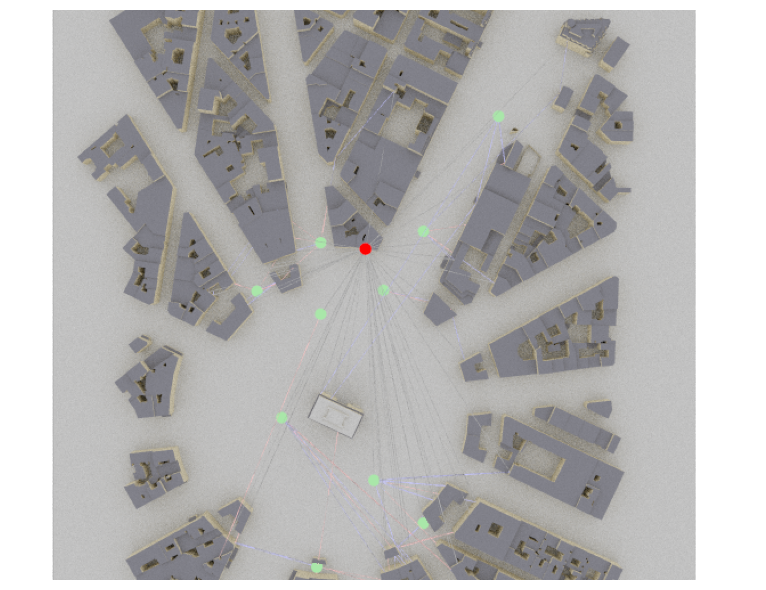

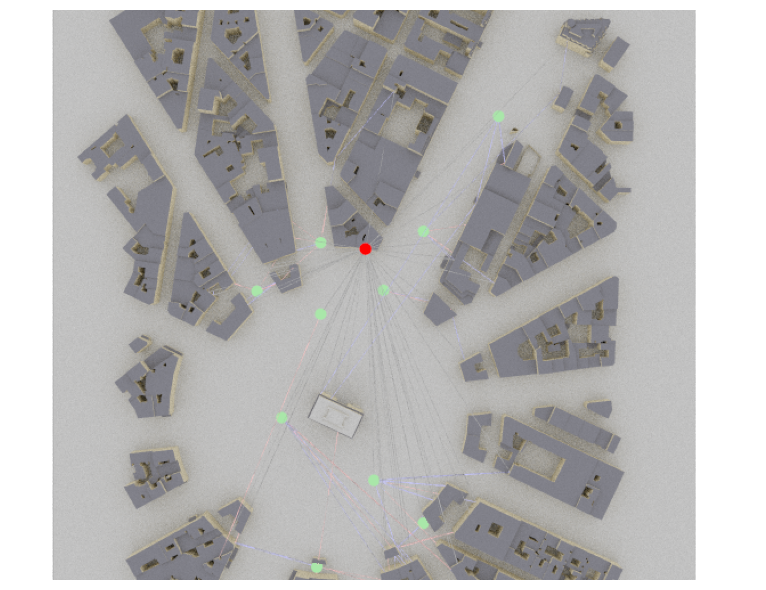

In [5]:
# scene.preview(paths=paths, radio_map = rm1, clip_at=20)
# x is approx up-down, y is approx left-right
bird_cam = sionna.rt.Camera(position = [-5,-10,950], look_at = [-5,-10,0])
scene.render(camera = bird_cam, paths = paths, num_samples = 64)
# scene.render_to_file(camera = bird_cam, filename="mu_mimo_radiomap_noZF.png", paths = paths, radio_map = rm, num_samples = 64)

Text(0.5, 1.0, 'User Locations in Z = 1.83 Plane')

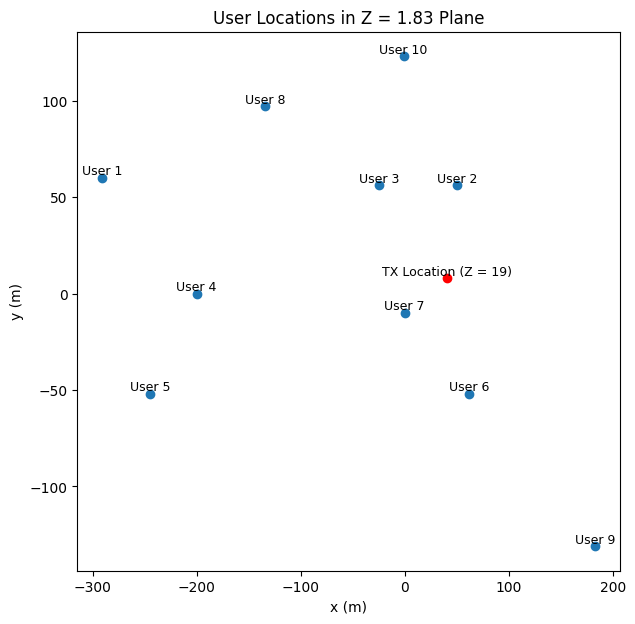

In [6]:
user_positions_3d = np.array(rx_pos)
user_positions_2d = user_positions_3d[:, :2]
plt.figure(figsize = (7,7))
plt.scatter(user_positions_2d[:, 0], user_positions_2d[:, 1])
plt.scatter(TX_LOC[0], TX_LOC[1], c='red')
plt.text(TX_LOC[0], TX_LOC[1], "TX Location (Z = 19)", fontsize = 9, ha = 'center', va = 'bottom')
for i, (x,y) in enumerate(user_positions_2d):
    plt.text(x, y, f"User {i + 1}", fontsize = 9, ha = 'center', va = 'bottom')
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title(f"User Locations in Z = {UE_Z} Plane")

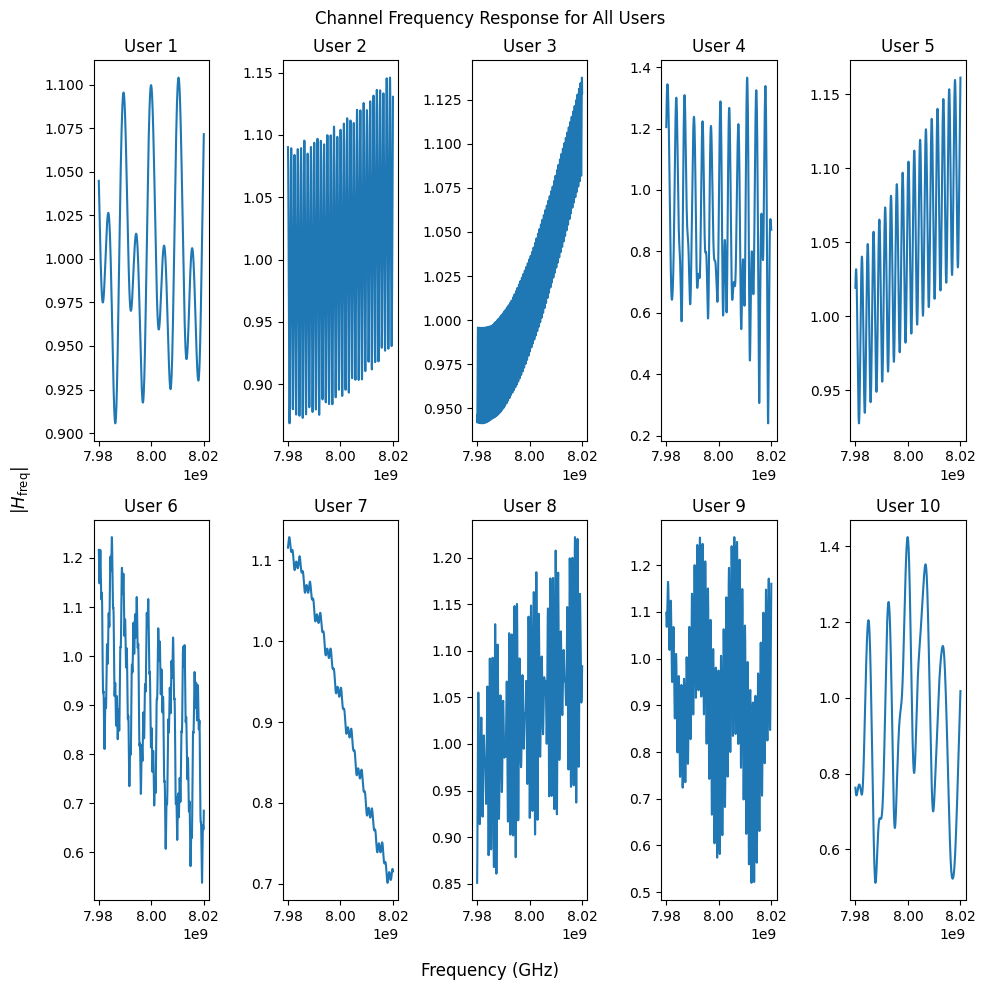

In [7]:
nfreqs = 1000
sweep_freqs = np.linspace(FC-BW, FC+BW, num=nfreqs)
h_freq_sweep = paths.cfr(frequencies=sweep_freqs,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")
abs_h_fs = np.abs(h_freq_sweep)
h_freq_FC = paths.cfr(frequencies=FC,
                   normalize=True, # Normalize energy
                   normalize_delays=True,
                   out_type="numpy")
abs_h_fc = np.abs(h_freq_FC)
h_freq = h_freq_FC.reshape(10,50)
abs_h_freq = np.abs(h_freq)
# Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_time_steps, num_subcarriers]

fig1, axs1 = plt.subplots(2,5, figsize = (10,10))
axs1 = axs1.flatten()

for i, ax in enumerate(axs1):
    ax.plot(sweep_freqs, abs_h_fs[i,0,0,0,0,:])
    ax.set_title(f"User {i + 1}")
    # ax.set_xlabel("Frequency (GHz)")
    # ax.set_ylabel(r"|$h_\text{freq}$|")

fig1.supxlabel("Frequency (GHz)")
fig1.supylabel(r"|$H_\text{freq}$|")
fig1.suptitle("Channel Frequency Response for All Users")
plt.tight_layout()
plt.show()

# a, tau = paths.cir(normalize_delays=True, out_type="numpy")

# # Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
# print("Shape of a: ", a.shape)

# # Shape: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths]
# print("Shape of tau: ", tau.shape)

# t = tau[0,0,:]/1e-9 # Scale to ns
# a_abs = np.abs(a)[0,0,0,0,:,0]
# a_max = np.max(a_abs)

# # # And plot the CIR
# plt.figure()
# plt.title("Channel impulse response")
# plt.stem(t, a_abs)
# plt.xlabel(r"$\tau$ [ns]")
# plt.ylabel(r"$|a|$")

# figi, axsi = plt.subplots(2,5, figsize = (10,10))
# axsi = axsi.flatten()

# for i, ax in enumerate(axsi):
#     ax.plot(tau[i,0,:]/1e-9, np.abs(a)[i,0,0,0,:,0])
#     ax.set_title(f"User {i + 1}")
#     # ax.set_xlabel("Frequency (GHz)")
#     # ax.set_ylabel(r"|$h_\text{freq}$|")

# figi.supxlabel(r"$\tau$ [ns]")
# figi.supylabel(r"$|a|$")
# figi.suptitle("Channel Impulse Response for All Users")
# plt.tight_layout()
# plt.show()

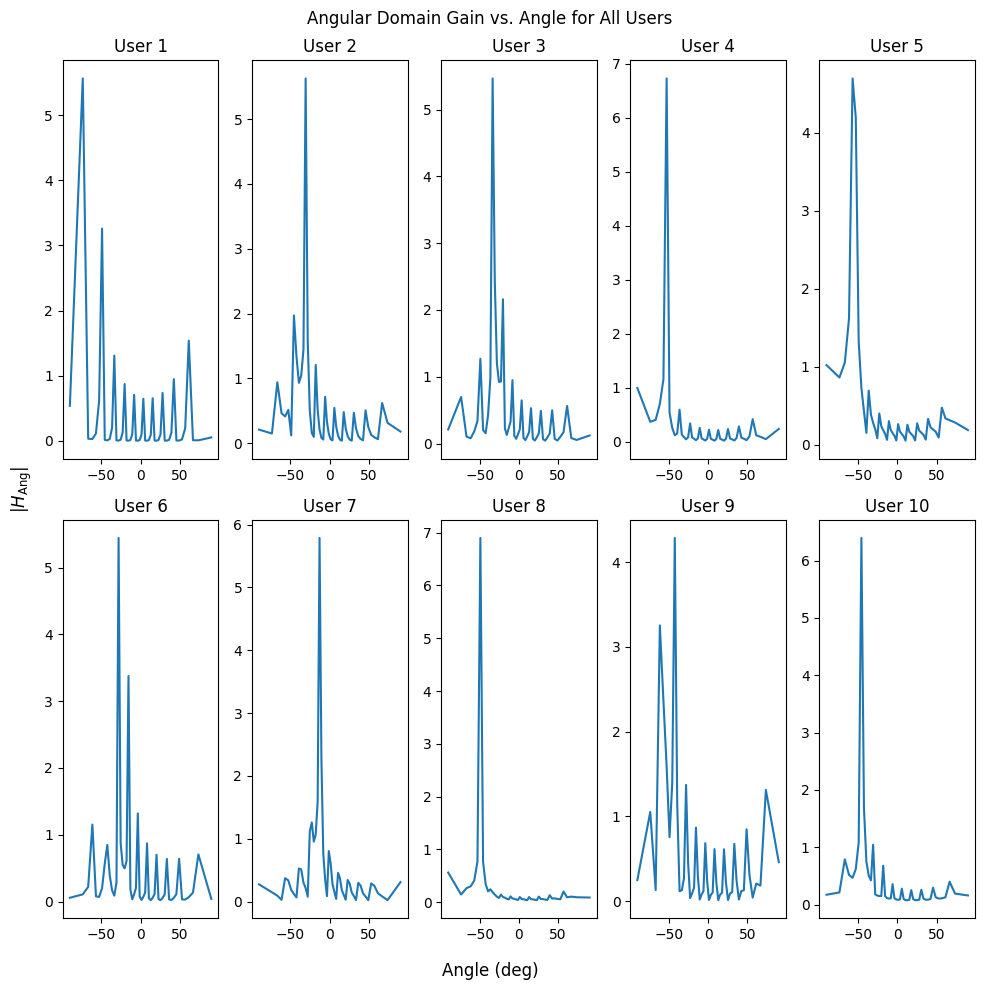

In [8]:
Ut = create_U_P2P(N_TX, D_BY_LAMBDA)
H = h_freq
Ha = h_freq @ Ut
abs_Ha = np.abs(Ha)
# plt.figure(figsize = (10,10))
# for k in range(N_RX):
#     gain = np.abs(Ha)[k]
#     plt.plot(gain, label = f"User {k + 1}")

angs_deg = np.arcsin(np.linspace(-1, 1, N_TX)) * 180 /PI
fig2, axs2 = plt.subplots(2,5, figsize = (10,10))
axs2 = axs2.flatten()

for i, ax in enumerate(axs2):
    ax.plot(angs_deg, abs_Ha[i])
    ax.set_title(f"User {i + 1}")

fig2.supxlabel("Angle (deg)")
fig2.supylabel(r"|$H_\text{Ang}$|")
fig2.suptitle("Angular Domain Gain vs. Angle for All Users")
plt.tight_layout()
plt.show()

In [9]:
W = H.conj().T @ np.linalg.inv(H @ H.conj().T) #unnormalized
W = W / np.linalg.norm(W, 'fro') #total power (frobenius) normalization
Wa = Ha.conj().T @ np.linalg.inv(Ha @ Ha.conj().T) #normalized
Wa =  Wa / np.linalg.norm(Wa, 'fro') #total power (frobenius) normalization
abs_W = np.abs(W)
abs_Wa = np.abs(Wa)
H_ZF = H @ W
Ha_ZF = Ha @ Wa
abs_H_ZF = np.abs(H_ZF)
abs_Ha_ZF = np.abs(Ha_ZF)
print(H_ZF.shape)

(10, 10)


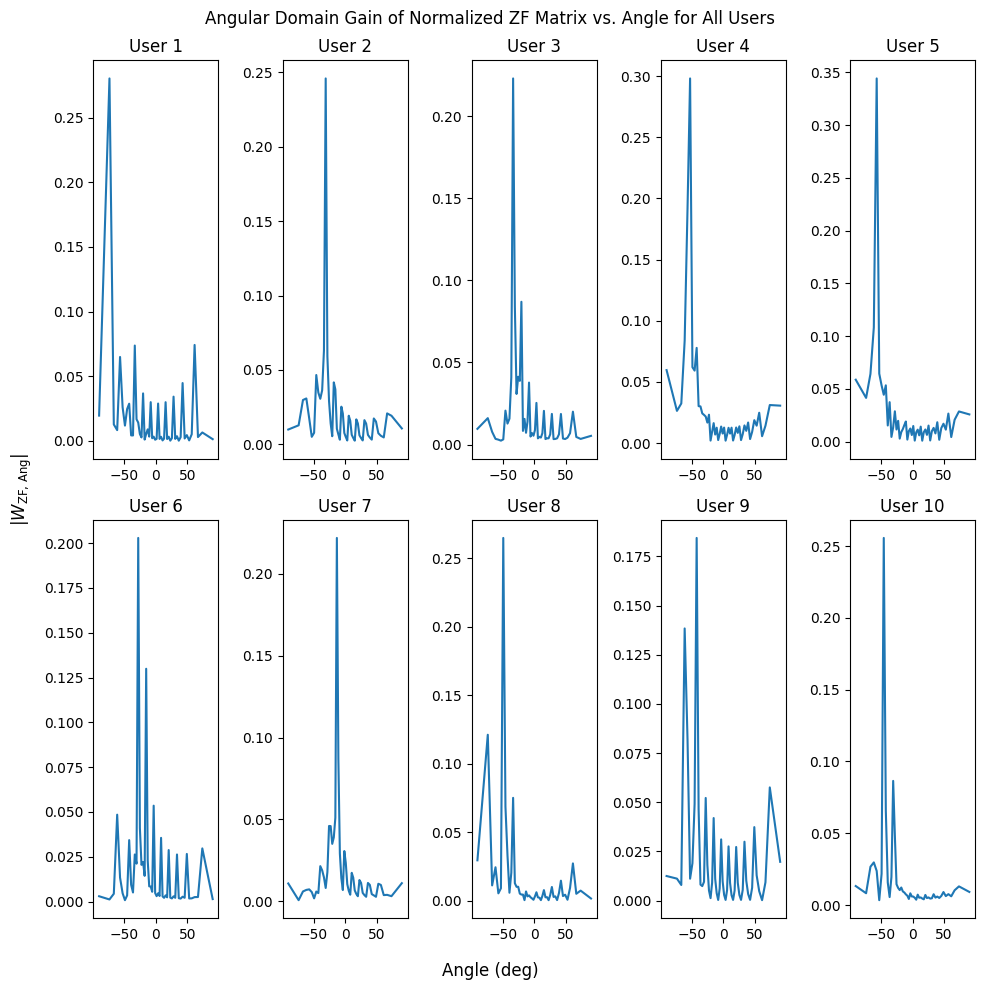

In [10]:
fig3, axs3 = plt.subplots(2,5, figsize = (10,10))
axs3 = axs3.flatten()

for i, ax in enumerate(axs3):
    ax.plot(angs_deg, abs_Wa[:, i], label = f"Wa for User {i}")
    # ax.plot(angs_deg, abs_Ha[i, :], label = f"Ha for User {i}")
    ax.set_title(f"User {i + 1}")
    # ax.legend()

fig3.supxlabel("Angle (deg)")
fig3.supylabel(r"|$W_\text{ZF, Ang}$|")
fig3.suptitle("Angular Domain Gain of Normalized ZF Matrix vs. Angle for All Users")
plt.tight_layout()
plt.show()

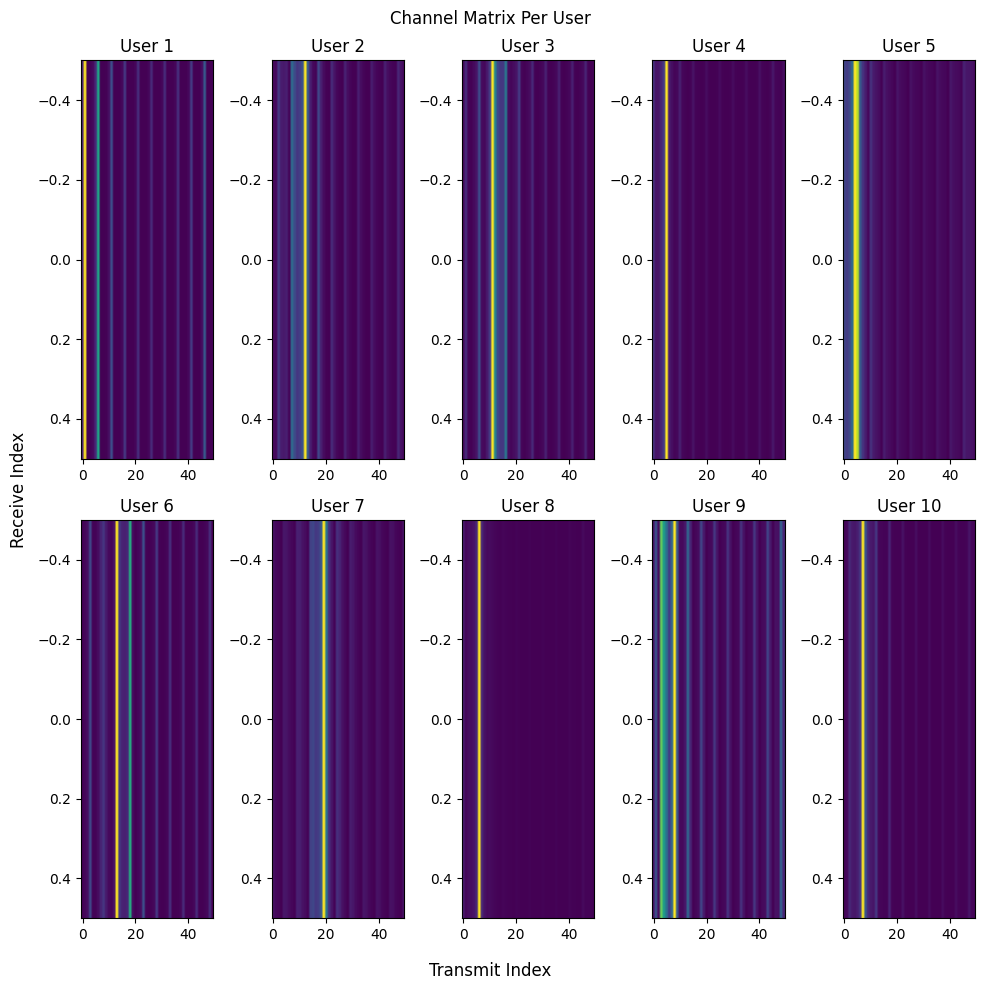

In [11]:
fig4, axs4 = plt.subplots(2,5, figsize = (10,10))
axs4 = axs4.flatten()

for i, ax in enumerate(axs4):
    im = ax.imshow(abs_Ha[i, :].reshape(50, 1).T, aspect = 'auto')
    ax.set_title(f"User {i + 1}")

fig4.supxlabel("Transmit Index")
fig4.supylabel("Receive Index")
fig4.suptitle("Channel Matrix Per User")
# fig4.colorbar(mappable=im,ax=axs4.ravel(), orientation='vertical', shrink=0.2, label='Magnitude', cmap='cool')
plt.tight_layout()

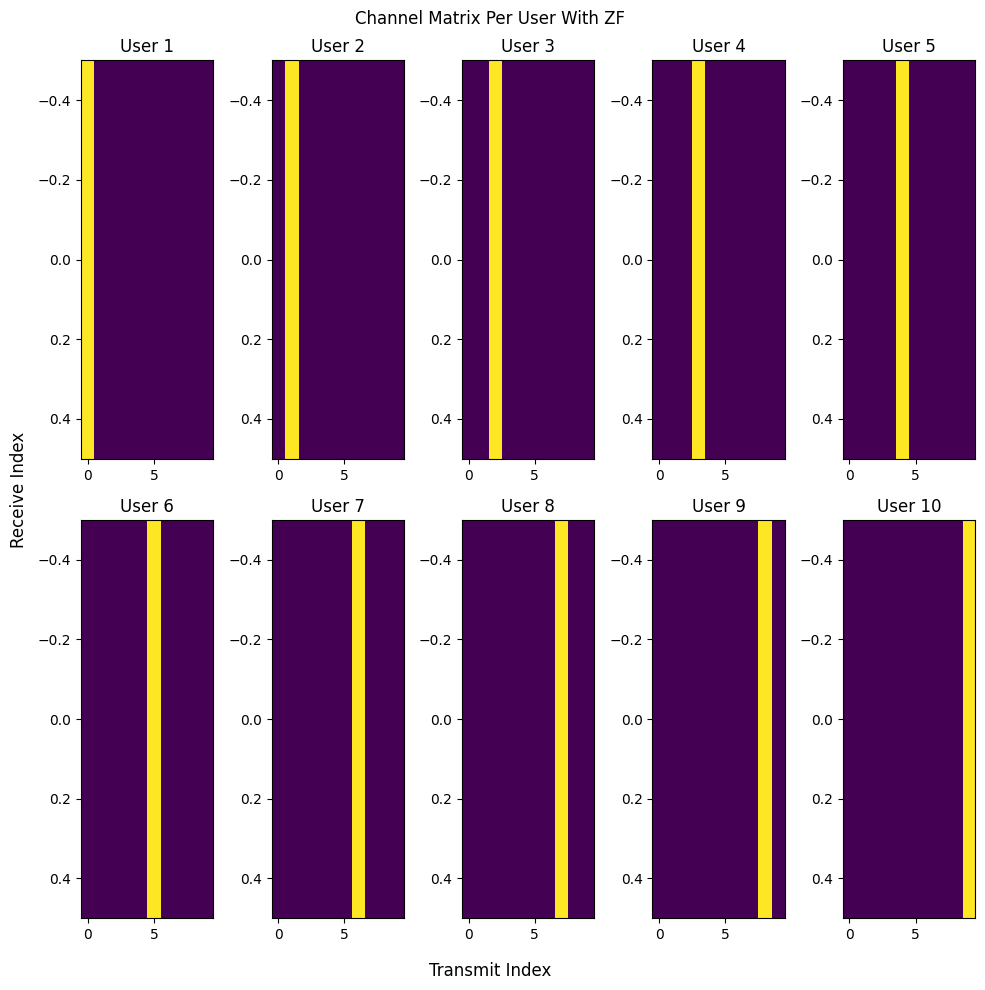

In [12]:
fig5, axs5 = plt.subplots(2,5, figsize = (10,10))
axs5 = axs5.flatten()

for i, ax in enumerate(axs5):
    im = ax.imshow(abs_Ha_ZF[i, :].reshape(10, 1).T, aspect = 'auto')
    ax.set_title(f"User {i + 1}")

fig5.supxlabel("Transmit Index")
fig5.supylabel("Receive Index")
fig5.suptitle("Channel Matrix Per User With ZF")
# fig5.colorbar(mappable=im,ax=axs5.ravel(), orientation='vertical', shrink=0.6, label='Magnitude', cmap='cool')
plt.tight_layout()

[-0.9486833 -0.9486833j  -0.9486833 -0.31622777j -0.9486833 +0.31622777j
 -0.9486833 +0.9486833j  -0.31622777-0.9486833j  -0.31622777-0.31622777j
 -0.31622777+0.31622777j -0.31622777+0.9486833j   0.31622777-0.9486833j
  0.31622777-0.31622777j  0.31622777+0.31622777j  0.31622777+0.9486833j
  0.9486833 -0.9486833j   0.9486833 -0.31622777j  0.9486833 +0.31622777j
  0.9486833 +0.9486833j ]


(-1.5, 1.5)

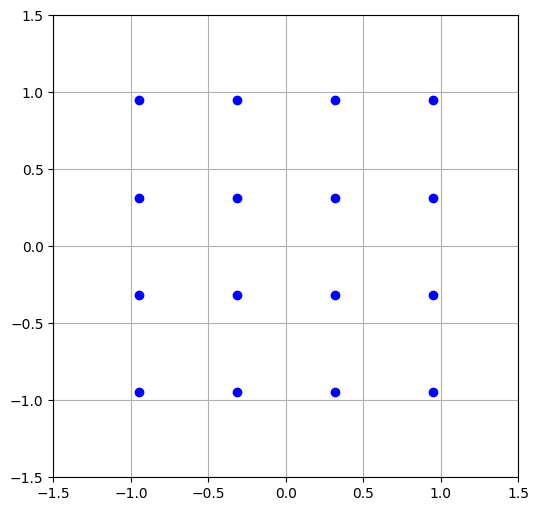

In [13]:
levels = [-3, -1, 1, 3]
constellation = [complex(i, q) for i in levels for q in levels]
qam16_vector = np.array(constellation)

rms = np.sqrt(np.mean(np.abs(qam16_vector)**2))
qam16_normalized = qam16_vector / rms
print(qam16_normalized)
plt.figure(figsize=(6,6))
plt.plot(qam16_normalized.real, qam16_normalized.imag, 'bo')
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

In [14]:
# constellation_power = 1
# sinr_arr = []
# s = constellation_power * np.random.choice(qam16_normalized, size=(N_RX,))
# print("s = ", s)
# n = (np.random.randn(N_RX,) + 1j * np.random.randn(N_RX,)) / np.sqrt(2)
# print("n = ", n)
# p_sig = np.abs(H @ W @ s)**2
# p_noise = np.abs(n)**2
# print("P_sig: ", p_sig)
# print("P_noise: ", p_noise)
# mean_p_sig = np.mean(p_sig)
# mean_p_noise = np.mean(p_noise)
# avg_sinr_per_user = mean_p_sig / mean_p_noise
# sinr_per_user = p_sig / p_noise

# capacity_total_bpsHz = 0
# for n in range(N_RX):
#     capacity_total_bpsHz = np.log2(1 + avg_sinr_per_user)

# print("Avg. SINR Per User: ", avg_sinr_per_user)
# for user, sinr in enumerate(sinr_per_user):
#     print(f"User {user + 1} SINR: {sinr}")
# print("Capacity (bit/s/Hz) : ", capacity_total_bpsHz)

# print("Average SINR Per User Avg over 10000x: ", mc_avg_sinr_user)

In [40]:
constellation_power = 1
sinr_arr = []
s = constellation_power * np.random.choice(qam16_normalized, size=(N_RX,))
# print("s = ", s)
n = (np.random.randn(N_RX,) + 1j * np.random.randn(N_RX,)) / np.sqrt(2)
# print("n = ", n)
# p_sig = np.abs(H @ W @ s)**2
# p_noise = np.abs(n)**2
for i in range(10000):
    s = constellation_power * np.random.choice(qam16_normalized, size=(N_RX,))
    # print("s = ", s)
    n = (np.random.randn(N_RX,) + 1j * np.random.randn(N_RX,)) / np.sqrt(2)
    # print("n = ", n)
    p_sig = np.abs(H @ W @ s)**2
    p_noise = np.abs(n)**2
    sinr_arr.append(p_sig / p_noise)

stacked = np.stack(sinr_arr)
# print("sinr arr: ", sinr_arr)
avg_sinr_per_user = np.mean(stacked, axis = 0)
db_avg_sinr = 10 * np.log10(avg_sinr_per_user)
df = pd.DataFrame(db_avg_sinr, columns = ["User Average SINR (dB)"])
capacity_total_bpsHz = np.log2(1 + np.mean(avg_sinr_per_user))

# print("Avg. SINR Per User: ", avg_sinr_per_user)
# for user, sinr in enumerate(sinr_per_user):
#     print(f"User {user + 1} SINR: {sinr}")
print("Capacity (bit/s/Hz) : ", capacity_total_bpsHz)

# print("Average SINR Per User Avg over 10000x: ", mc_avg_sinr_user)

Capacity (bit/s/Hz) :  5.188897668089608


In [41]:
df

,User Average SINR (dB)
0,17.435990
1,15.006942
2,14.980202
3,16.449418
4,15.177167
5,13.682134
6,15.017747
7,15.470582
8,16.477981
9,13.861188


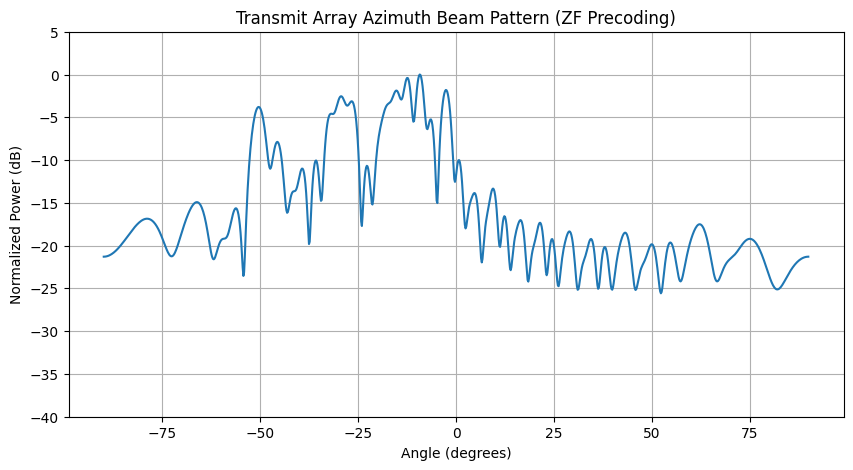

In [15]:
angles = np.linspace(-90, 90, 1000) #azimuth angles in degrees
theta_rad = np.radians(angles)

def steering_vector(theta, N):
    return np.exp(1j * 2 * np.pi * D_BY_LAMBDA * np.arange(N) * np.sin(theta)).reshape(-1, 1)

beam_pattern = []
for theta in theta_rad:
    a = steering_vector(theta, N_TX)
    power = np.linalg.norm(a.conj().T @ W)**2
    beam_pattern.append(power)

beam_pattern = 10 * np.log10(np.abs(beam_pattern) / np.max(beam_pattern))

plt.figure(figsize=(10, 5))
plt.plot(angles, beam_pattern)
plt.grid(True)
plt.title("Transmit Array Azimuth Beam Pattern (ZF Precoding)")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.ylim(-40, 5)
plt.show()

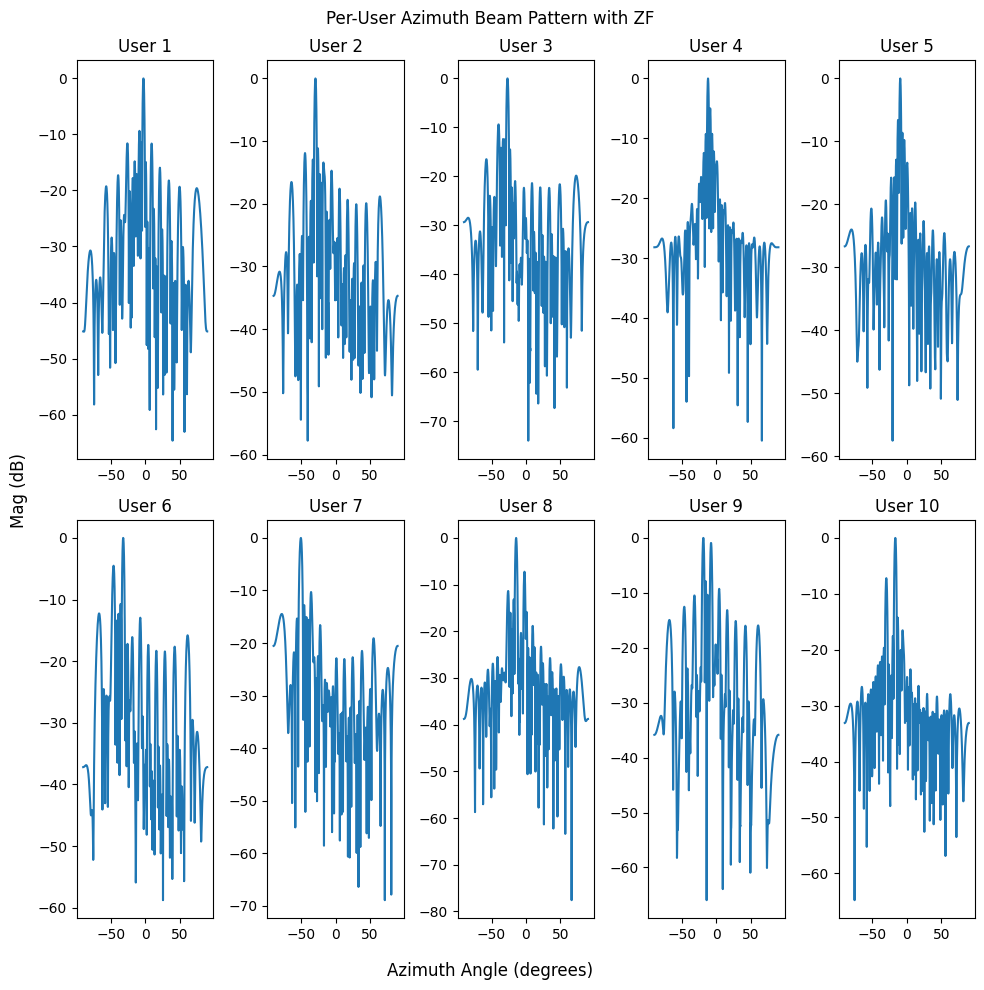

In [16]:
W = H.conj().T @ np.linalg.inv(H @ H.conj().T) #unnormalized
W = W / np.linalg.norm(W, axis=0, keepdims=True)

# Compute beam pattern for each user stream
beam_patterns = np.zeros((N_RX, len(theta_rad)))

for k in range(N_RX):
    wk = W[:, k].reshape(-1, 1)
    for idx, theta in enumerate(theta_rad):
        a = steering_vector(theta, N_TX)
        beam_patterns[k, idx] = (np.abs(a.conj().T @ wk)**2).item()

# Normalize per user
beam_patterns_db = 10 * np.log10(beam_patterns / np.max(beam_patterns, axis=1, keepdims=True))

fig6, axs6 = plt.subplots(2,5, figsize = (10,10))
axs6 = axs6.flatten()

for i, ax in enumerate(axs6):
    ax.plot(angles, beam_patterns_db[i])
    ax.set_title(f"User {i + 1}")

fig6.supxlabel("Azimuth Angle (degrees)")
fig6.supylabel("Mag (dB)")
fig6.suptitle("Per-User Azimuth Beam Pattern with ZF")
plt.tight_layout()

In [59]:
def cell_2_metric(cell_x, cell_y, rm, metric = "path_gain"):
    
    #the size of the radiomap must be larger than the largest distance of one of the receivers
    #or else the indices blow up to like max int or something
    arr = []
    for i in range(N_RX):
        if metric == "path_gain" :
            pg = rm.path_gain.numpy()[0, cell_y[i], cell_x[i]]
            arr.append(pg)
        elif metric == "sinr":
            pg = rm.sinr.numpy()[0, cell_y[i], cell_x[i]]
            arr.append(pg)
        elif metric == "rss":
            pg = rm.rss.numpy()[0, cell_y[i], cell_x[i]]
            arr.append(pg)
    return arr

# user = 0

# precoding_vec = (mi.TensorXf(W[:, user].real), mi.TensorXf(W[:, user].imag))

rm_raw = rm_solver(scene,
                max_depth=8,           # Maximum number of ray scene interactions
                samples_per_tx=10**6 , # If you increase: less noise, but more memory required
                cell_size=(1, 1),      # Resolution of the radio map
                center=[0, 0, 0],      # Center of the radio map
                size=[600, 400],       # Total size of the radio map
                orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical
rxcells_raw_x = rm_raw.rx_cell_indices.x.numpy()
rxcells_raw_y = rm_raw.rx_cell_indices.y.numpy()
# rm_precoded = rm_solver(scene,
#                 max_depth=8,           # Maximum number of ray scene interactions
#                 samples_per_tx=10**6 , # If you increase: less noise, but more memory required
#                 cell_size=(1, 1),      # Resolution of the radio map
#                 precoding_vec = precoding_vec,
#                 center=[0, 0, 0],      # Center of the radio map
#                 size=[600, 400],       # Total size of the radio map
#                 orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical
# rxcells_precoded_x = rm_precoded.rx_cell_indices.x.numpy()
# rxcells_precoded_y = rm_precoded.rx_cell_indices.y.numpy()

In [60]:
raw_sinr = cell_2_metric(rxcells_raw_x, rxcells_raw_y, rm_raw, "sinr")
print(raw_sinr)

[0.0, 0.0, 0.0, 0.0, 0.0, 135.60666, 32183.629, 0.0, 0.0, 2.1399157]


In [61]:
precoded_sinr = []
for k in range(N_RX):
    user = k
    precoding_vec = (mi.TensorXf(W[:, user].real), mi.TensorXf(W[:, user].imag))
    rm_precoded = rm_solver(scene,
                max_depth=8,           # Maximum number of ray scene interactions
                samples_per_tx=10**6 , # If you increase: less noise, but more memory required
                cell_size=(1, 1),      # Resolution of the radio map
                precoding_vec = precoding_vec,
                center=[0, 0, 0],      # Center of the radio map
                size=[600, 400],       # Total size of the radio map
                orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical
    rxcells_precoded_x = rm_precoded.rx_cell_indices.x.numpy()
    rxcells_precoded_y = rm_precoded.rx_cell_indices.y.numpy()
    precoded_sinr.append(cell_2_metric(rxcells_precoded_x, rxcells_precoded_y, rm_precoded, "sinr"))

In [62]:
precoded_sinr

[[0.0, 0.0, 0.0, 0.0, 0.0, 4318.9624, 55.307632, 0.0, 0.0, 92.86388],
 [0.0, 0.0, 0.0, 0.0, 0.0, 117815.98, 857.57404, 0.0, 0.0, 59779.547],
 [0.0, 0.0, 0.0, 0.0, 0.0, 26098.676, 394.39337, 0.0, 0.0, 26972.463],
 [0.0, 0.0, 0.0, 0.0, 0.0, 4848.0713, 3784.0496, 0.0, 0.0, 464.04593],
 [0.0, 0.0, 0.0, 0.0, 0.0, 2602.031, 19598.941, 0.0, 0.0, 292.0772],
 [0.0, 0.0, 0.0, 0.0, 0.0, 19916106.0, 3561.1282, 0.0, 0.0, 5537.553],
 [0.0, 0.0, 0.0, 0.0, 0.0, 1468.4497, 24278190.0, 0.0, 0.0, 270.98572],
 [0.0, 0.0, 0.0, 0.0, 0.0, 14316.2, 351.60275, 0.0, 0.0, 13.0261965],
 [0.0, 0.0, 0.0, 0.0, 0.0, 13836.693, 3235.234, 0.0, 0.0, 391.50504],
 [0.0, 0.0, 0.0, 0.0, 0.0, 51997.22, 1172.2505, 0.0, 0.0, 52312.156]]